# 1. Imports


1. Verify hd-bet works for PET images (try with and without skull)
     -> If not look at bet2
   
3. Try in Native space rather than MNI space
   
4. Try ADC if available

5. Expand Dataset
   
     -> Check unprocessed data, ADNI data (possibly ADNI for validation later)

6. Read literature and try different architectures
   
    -> Log metrics on test set after each experiment
        (SSIM, MSE, Inception score)

If use department GPU, make sure don't hog resources (esp if running overnight)

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.utils import progress_bar
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)
from monai.losses.ssim_loss import SSIMLoss
import statistics

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,5,7"

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

In [4]:
# global variables
image_size = (128,128,64)

# 2. MONAI Dataloader

In [5]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair", "pet"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair", "pet"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Resized(keys=["t1", "t1c", "t2", "flair", "pet"], spatial_size=image_size),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair", "pet"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.6, range_z=0.3)
    ]
)

In [7]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 17.195478200912476 seconds since the loop started


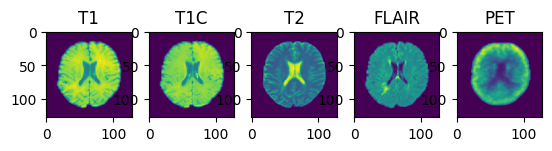

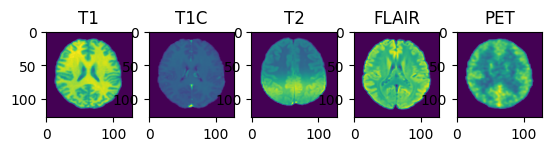

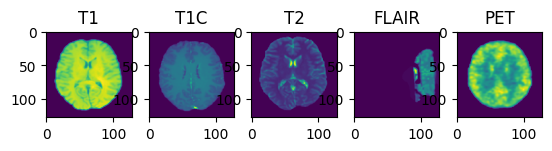

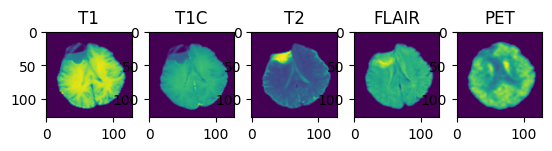

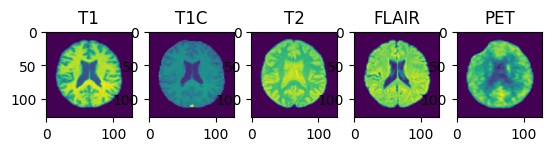

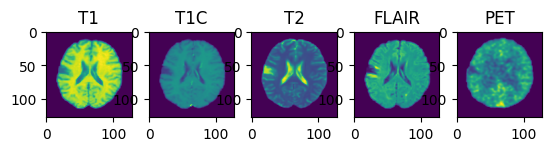

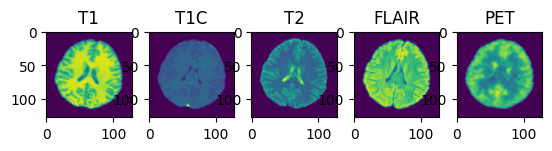

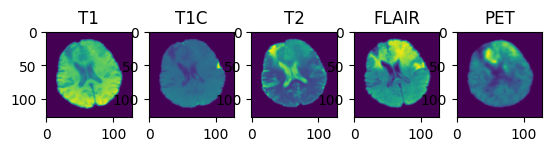

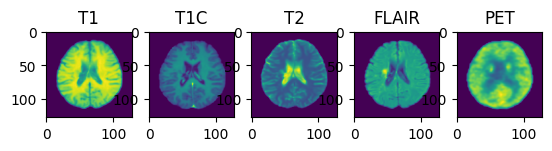

In [8]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index]
    
    f, axarr = plt.subplots(1, 5)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    axarr[4].imshow(image_datas[4])
    axarr[4].set_title("PET")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

In [9]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

train_metric_ds = CacheDataset(data=dictionary_train[:10], transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_metric_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

80


Loading dataset:   0%|                                                                                                                                  | 0/185 [00:00<?, ?it/s]

Loading dataset:   1%|▋                                                                                                                       | 1/185 [00:56<2:53:02, 56.42s/it]

Loading dataset:   1%|█▎                                                                                                                      | 2/185 [00:58<1:13:46, 24.19s/it]

Loading dataset:   2%|█▉                                                                                                                        | 3/185 [00:59<42:07, 13.89s/it]

Loading dataset:   2%|██▋                                                                                                                       | 4/185 [00:59<25:35,  8.48s/it]

Loading dataset:   3%|███▎                                                                                                                      | 5/185 [01:01<18:27,  6.16s/it]

Loading dataset:   3%|███▉                                                                                                                      | 6/185 [01:04<15:05,  5.06s/it]

Loading dataset:   4%|████▌                                                                                                                     | 7/185 [01:06<11:30,  3.88s/it]

Loading dataset:   4%|█████▎                                                                                                                    | 8/185 [01:06<08:12,  2.78s/it]

Loading dataset:   5%|█████▉                                                                                                                    | 9/185 [01:09<07:56,  2.71s/it]

Loading dataset:   5%|██████▌                                                                                                                  | 10/185 [01:10<06:27,  2.22s/it]

Loading dataset:   6%|███████▏                                                                                                                 | 11/185 [01:16<07:55,  2.73s/it]

Loading dataset:   6%|███████▊                                                                                                                 | 12/185 [01:16<07:30,  2.61s/it]

Loading dataset:   7%|████████▌                                                                                                                | 13/185 [01:16<05:29,  1.92s/it]

Loading dataset:   8%|█████████▏                                                                                                               | 14/185 [01:19<05:45,  2.02s/it]

Loading dataset:   8%|█████████▊                                                                                                               | 15/185 [01:19<04:24,  1.56s/it]

Loading dataset:   9%|██████████▍                                                                                                              | 16/185 [01:21<04:13,  1.50s/it]

Loading dataset:   9%|███████████                                                                                                              | 17/185 [01:23<05:04,  1.81s/it]

Loading dataset:  10%|███████████▊                                                                                                             | 18/185 [01:24<04:03,  1.46s/it]

Loading dataset:  10%|████████████▍                                                                                                            | 19/185 [01:25<03:52,  1.40s/it]

Loading dataset:  11%|█████████████                                                                                                            | 20/185 [01:26<03:18,  1.21s/it]

Loading dataset:  11%|█████████████▋                                                                                                           | 21/185 [01:27<03:03,  1.12s/it]

Loading dataset:  12%|██████████████▍                                                                                                          | 22/185 [01:31<05:19,  1.96s/it]

Loading dataset:  12%|███████████████                                                                                                          | 23/185 [01:32<04:53,  1.81s/it]

Loading dataset:  13%|███████████████▋                                                                                                         | 24/185 [01:36<06:13,  2.32s/it]

Loading dataset:  14%|████████████████▎                                                                                                        | 25/185 [01:36<04:54,  1.84s/it]

Loading dataset:  14%|█████████████████                                                                                                        | 26/185 [01:37<03:42,  1.40s/it]

Loading dataset:  15%|█████████████████▋                                                                                                       | 27/185 [01:39<04:28,  1.70s/it]

Loading dataset:  15%|██████████████████▎                                                                                                      | 28/185 [01:41<04:19,  1.66s/it]

Loading dataset:  16%|██████████████████▉                                                                                                      | 29/185 [01:41<03:29,  1.34s/it]

Loading dataset:  16%|███████████████████▌                                                                                                     | 30/185 [01:41<02:39,  1.03s/it]

Loading dataset:  17%|████████████████████▎                                                                                                    | 31/185 [01:42<02:33,  1.00it/s]

Loading dataset:  17%|████████████████████▉                                                                                                    | 32/185 [01:43<01:57,  1.30it/s]

Loading dataset:  18%|█████████████████████▌                                                                                                   | 33/185 [01:43<01:57,  1.29it/s]

Loading dataset:  18%|██████████████████████▏                                                                                                  | 34/185 [01:44<01:58,  1.28it/s]

Loading dataset:  19%|██████████████████████▉                                                                                                  | 35/185 [01:46<02:48,  1.13s/it]

Loading dataset:  19%|███████████████████████▌                                                                                                 | 36/185 [01:47<02:44,  1.10s/it]

Loading dataset:  20%|████████████████████████▏                                                                                                | 37/185 [01:48<02:34,  1.04s/it]

Loading dataset:  21%|████████████████████████▊                                                                                                | 38/185 [01:49<02:17,  1.07it/s]

Loading dataset:  21%|█████████████████████████▌                                                                                               | 39/185 [01:49<01:51,  1.31it/s]

Loading dataset:  22%|██████████████████████████▏                                                                                              | 40/185 [01:50<02:04,  1.17it/s]

Loading dataset:  22%|██████████████████████████▊                                                                                              | 41/185 [01:51<01:50,  1.31it/s]

Loading dataset:  23%|███████████████████████████▍                                                                                             | 42/185 [01:52<01:50,  1.30it/s]

Loading dataset:  23%|████████████████████████████                                                                                             | 43/185 [01:52<01:25,  1.66it/s]

Loading dataset:  24%|████████████████████████████▊                                                                                            | 44/185 [01:52<01:13,  1.92it/s]

Loading dataset:  24%|█████████████████████████████▍                                                                                           | 45/185 [01:52<00:59,  2.34it/s]

Loading dataset:  25%|██████████████████████████████                                                                                           | 46/185 [01:52<00:47,  2.90it/s]

Loading dataset:  25%|██████████████████████████████▋                                                                                          | 47/185 [01:53<00:43,  3.17it/s]

Loading dataset:  44%|████████████████████████████████████████████████████▉                                                                    | 81/185 [01:54<00:04, 23.84it/s]

Loading dataset:  45%|██████████████████████████████████████████████████████▎                                                                  | 83/185 [01:58<00:21,  4.82it/s]

Loading dataset:  46%|███████████████████████████████████████████████████████▌                                                                 | 85/185 [01:58<00:19,  5.12it/s]

Loading dataset:  47%|████████████████████████████████████████████████████████▉                                                                | 87/185 [02:05<00:56,  1.72it/s]

Loading dataset:  48%|█████████████████████████████████████████████████████████▌                                                               | 88/185 [02:07<01:03,  1.53it/s]

Loading dataset:  48%|██████████████████████████████████████████████████████████▏                                                              | 89/185 [02:08<01:09,  1.39it/s]

Loading dataset:  49%|██████████████████████████████████████████████████████████▊                                                              | 90/185 [02:09<01:14,  1.28it/s]

Loading dataset:  49%|███████████████████████████████████████████████████████████▌                                                             | 91/185 [02:11<01:26,  1.08it/s]

Loading dataset:  50%|████████████████████████████████████████████████████████████▏                                                            | 92/185 [02:11<01:16,  1.21it/s]

Loading dataset:  50%|████████████████████████████████████████████████████████████▊                                                            | 93/185 [02:12<01:07,  1.37it/s]

Loading dataset:  51%|█████████████████████████████████████████████████████████████▍                                                           | 94/185 [02:12<00:56,  1.61it/s]

Loading dataset:  51%|██████████████████████████████████████████████████████████████▏                                                          | 95/185 [02:12<00:47,  1.90it/s]

Loading dataset:  58%|██████████████████████████████████████████████████████████████████████                                                  | 108/185 [02:12<00:08,  8.73it/s]

Loading dataset:  71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 131/185 [02:13<00:02, 21.96it/s]

Loading dataset:  77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 143/185 [02:13<00:01, 29.73it/s]

Loading dataset:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 154/185 [02:13<00:00, 32.14it/s]

Loading dataset:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 161/185 [02:13<00:00, 32.28it/s]

Loading dataset:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 166/185 [02:14<00:00, 28.41it/s]

Loading dataset:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 171/185 [02:14<00:00, 30.46it/s]

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [02:14<00:00,  1.38it/s]

Loading dataset:   0%|                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Loading dataset:  10%|████████████▎                                                                                                              | 1/10 [00:07<01:03,  7.07s/it]

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]

Loading dataset:   0%|                                                                                                                                    | 0/5 [00:00<?, ?it/s]

Loading dataset:  20%|████████████████████████▊                                                                                                   | 1/5 [00:02<00:11,  2.97s/it]

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]

Loading dataset:   0%|                                                                                                                                   | 0/57 [00:00<?, ?it/s]

Loading dataset:   2%|██▏                                                                                                                        | 1/57 [00:37<35:21, 37.88s/it]

Loading dataset:   4%|████▎                                                                                                                      | 2/57 [00:39<15:06, 16.49s/it]

Loading dataset:   9%|██████████▊                                                                                                                | 5/57 [00:39<04:05,  4.71s/it]

Loading dataset:  68%|███████████████████████████████████████████████████████████████████████████████████▍                                      | 39/57 [00:39<00:06,  2.65it/s]

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]

# 3. Model Setup


In [10]:
class GLA_Generator(nn.Module):
    def __init__(self):
        super(GLA_Generator, self).__init__()
        self.ahnet_global = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)

        channels = [4, 6, 12, 6, 4]
        strides = [1, 1, 1, 1, 1]
        
        self.ahnet_1 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_2 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_3 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_4 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)

        self.conv1 = nn.Conv3d(32, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu = nn.ReLU()
        #self.dropout = torch.nn.Dropout(0)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=1)
        self.bn2 = nn.BatchNorm3d(1)

    def forward(self, x):
        batch_size, channels, width, height, depth = x.shape
        half_width, half_height = width // 2, height // 2
        
        # Splitting the input into 4 patches
        patch_1 = x[:, :, :half_width, :half_height, :]
        patch_2 = x[:, :, :half_width, half_height:, :]
        patch_3 = x[:, :, half_width:, :half_height, :]
        patch_4 = x[:, :, half_width:, half_height:, :]

        x = self.ahnet_global(x)
        patch_1 = self.ahnet_1(patch_1)
        patch_2 = self.ahnet_2(patch_2)
        patch_3 = self.ahnet_3(patch_3)
        patch_4 = self.ahnet_4(patch_4)

        # Concatenating the processed patches
        top_row = torch.cat([patch_1, patch_2], dim=3)  # Concatenate along the height
        bottom_row = torch.cat([patch_3, patch_4], dim=3)  # Concatenate along the height
        concatenated_patches = torch.cat([top_row, bottom_row], dim=2)  # Concatenate along the width

        x = torch.cat([x, concatenated_patches], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return x

### 3.1 Model and Device Setup

In [11]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gen_net = GLA_Generator()

disc_net = monai.networks.nets.Discriminator(
    in_shape=(128, 128, 64),
    channels=(8, 16, 32, 64, 128, 64, 1),
    strides=(2, 2, 2, 2, 2, 1, 1),
    num_res_units=1,
    kernel_size=3,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    gen_net = nn.DataParallel(gen_net)
    disc_net = nn.DataParallel(disc_net)

gen_net.to(device)
disc_net.to(device)

real_label = 1
gen_label = 0

disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()
gen_loss2 = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, kernel_size=4)

disc_opt = torch.optim.Adam(disc_net.parameters(), 0.0001)
gen_opt = torch.optim.Adam(gen_net.parameters(), 0.0001)

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    # Training discriminator to label 1 on real images
    realloss = disc_loss(disc_net(real_images), real) 

    # Training discriminator to label 0 on generated images
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input, real_images):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input[:,0,:,:,:])
    cats = output.new_full(output.shape, real_label)
    fooling_disc = gen_loss(output, cats)
    ssim = 1 - torch.mean(gen_loss2(input, real_images))
    
    # Train generator to fool the discriminator into giving a score of 1, and to have a high SSIM
    return (0.5*fooling_disc) + ssim

cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Let's use 4 GPUs!


### 3.2 Training


----------
epoch 1/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:34, 102.86s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.47s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:17, 25.80s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.01s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.64s/it]

----------
epoch 2/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:15, 99.12s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.96s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 25.00s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.55s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.10s/it]

----------
epoch 3/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:49, 93.98s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.85s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.89s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.89s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.60s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.80s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.24s/it]

----------
epoch 4/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:31<07:37, 91.46s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:35<02:39, 39.76s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:38<01:09, 23.23s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:42<00:31, 15.58s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:46<00:11, 11.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00,  8.55s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00, 18.75s/it]

----------
epoch 5/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:31<07:37, 91.59s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:35<02:39, 39.84s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:39<01:10, 23.47s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:42<00:31, 15.60s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:46<00:11, 11.26s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00,  8.56s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00, 18.79s/it]

----------
epoch 6/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:47, 93.51s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.84s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.88s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.87s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.49s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.72s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.19s/it]

----------
epoch 7/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:32<07:42, 92.56s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:42, 40.60s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:11, 23.76s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:47<00:11, 11.45s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.70s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.05s/it]

----------
epoch 8/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:32<07:44, 93.00s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:41, 40.39s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:10, 23.57s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:43<00:31, 15.69s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:47<00:11, 11.32s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00,  8.71s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.02s/it]

----------
epoch 9/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:31<07:35, 91.18s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:34<02:38, 39.64s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:38<01:09, 23.16s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:41<00:30, 15.43s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:45<00:11, 11.29s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00,  8.57s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00, 18.72s/it]

----------
epoch 10/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:02, 96.57s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:47, 41.87s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:13, 24.42s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.19s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.80s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.93s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.59s/it]

----------
epoch 11/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:34<07:53, 94.72s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:44, 41.11s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.99s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:32, 16.08s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:49<00:11, 11.60s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.79s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.38s/it]

----------
epoch 12/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:34<07:50, 94.08s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.91s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:14, 24.71s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.40s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.81s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.93s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.53s/it]

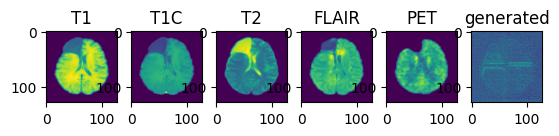

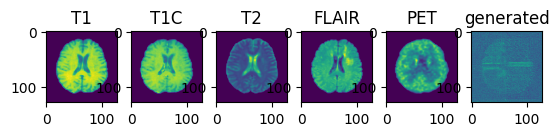

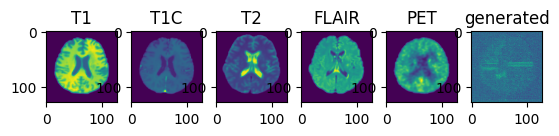

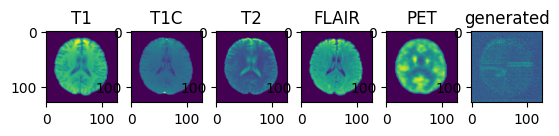

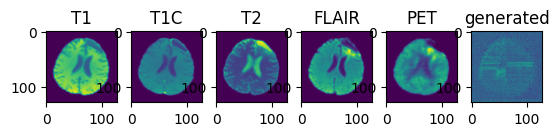

validation avg MS-SSIM: 0.0000 , train avg MS-SSIM: 0.0000
----------
epoch 13/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.14s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.29s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.06s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.13s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:49<00:11, 11.62s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.81s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.42s/it]

----------
epoch 14/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:47, 93.43s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:42, 40.62s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:13, 24.48s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.30s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:49<00:11, 11.73s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.92s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.39s/it]

----------
epoch 15/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:04, 96.94s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.10s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:14, 24.72s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.39s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.81s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.93s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.72s/it]

----------
epoch 16/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.83s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:52, 43.07s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.06s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.60s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.94s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.04s/it]

----------
epoch 17/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:28, 101.66s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:55, 43.97s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.56s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.90s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.12s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.25s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.49s/it]

----------
epoch 18/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:47, 93.53s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:42, 40.64s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:11, 23.75s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.41s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.81s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.16s/it]

----------
epoch 19/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.14s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.32s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.13s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.18s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.77s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.49s/it]

----------
epoch 20/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:56, 95.29s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.36s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.15s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.19s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.65s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.83s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.44s/it]

----------
epoch 21/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.09s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.26s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.28s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.13s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.63s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.83s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.38s/it]

----------
epoch 22/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:31<07:36, 91.38s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:35<02:40, 40.01s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:39<01:10, 23.40s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:42<00:31, 15.56s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:46<00:11, 11.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00,  8.56s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00, 18.78s/it]

----------
epoch 23/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:05, 97.14s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.41s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:14, 24.73s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.42s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.82s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.89s/it]

----------
epoch 24/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:28, 101.79s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.01s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:16, 25.59s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.93s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.16s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.26s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.56s/it]

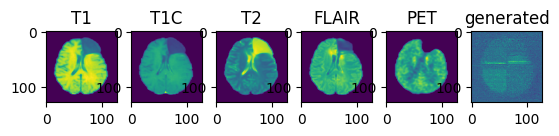

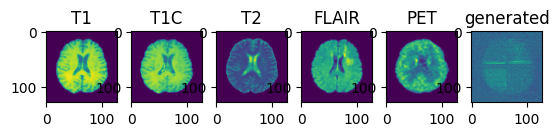

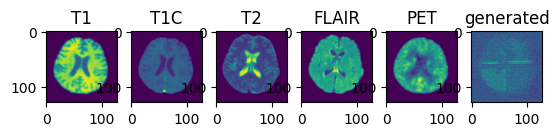

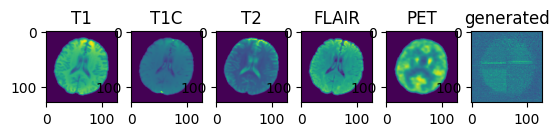

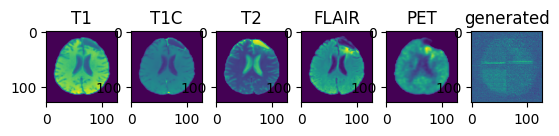

validation avg MS-SSIM: 0.2146 , train avg MS-SSIM: 0.2208
----------
epoch 25/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:06, 97.33s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.72s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.84s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.46s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.83s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.89s/it]

----------
epoch 26/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.47s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.09s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.05s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.60s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.94s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.08s/it]

----------
epoch 27/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.98s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.89s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.98s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.55s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.05s/it]

----------
epoch 28/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.37s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.06s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.03s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.59s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  8.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.01s/it]

----------
epoch 29/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.26s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 43.00s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.04s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.58s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.13s/it]

----------
epoch 30/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:09, 97.88s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.46s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.73s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.53s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.87s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.84s/it]

----------
epoch 31/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:43<08:35, 103.01s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:58, 44.55s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:18, 26.04s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:54<00:34, 17.20s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.31s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00,  9.32s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.76s/it]

----------
epoch 32/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.08s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.91s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.97s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.56s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.96s/it]

----------
epoch 33/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:32, 102.44s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.29s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.78s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.04s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.59s/it]

----------
epoch 34/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:58, 95.63s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:45, 41.49s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.22s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.10s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.60s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.56s/it]

----------
epoch 35/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.14s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.31s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.09s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.02s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.68s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.85s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.43s/it]

----------
epoch 36/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:46, 93.26s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:42, 40.53s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:10, 23.66s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.75s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.54s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.75s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.10s/it]

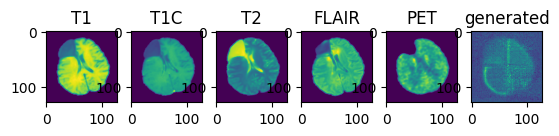

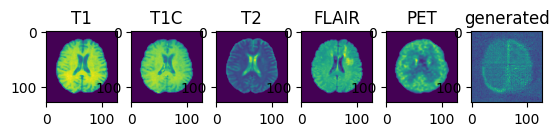

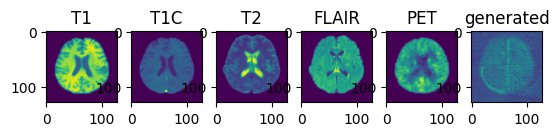

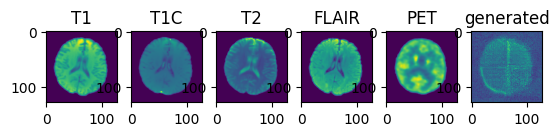

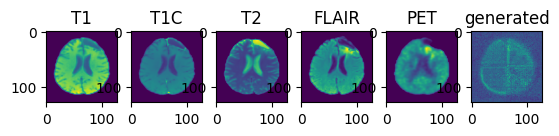

validation avg MS-SSIM: 0.3196 , train avg MS-SSIM: 0.3318
----------
epoch 37/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:11, 98.28s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.62s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.82s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.48s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.85s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.93s/it]

----------
epoch 38/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.41s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.78s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.31s/it]

----------
epoch 39/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.75s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.62s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.43s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.25s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.29s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.40s/it]

----------
epoch 40/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.55s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.55s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.34s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.94s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.38s/it]

----------
epoch 41/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:43<08:39, 103.84s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:47<02:59, 44.93s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:51<01:18, 26.29s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:55<00:34, 17.38s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:59<00:12, 12.45s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00,  9.38s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:05<00:00, 20.94s/it]

----------
epoch 42/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.83s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.22s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:17, 25.68s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.96s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.16s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.37s/it]

----------
epoch 43/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.48s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.84s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.47s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.24s/it]

----------
epoch 44/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:04, 96.95s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.08s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.51s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.26s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.70s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.87s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.65s/it]

----------
epoch 45/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:09, 97.91s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.46s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.74s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.45s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.89s/it]

----------
epoch 46/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.30s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.46s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.30s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.73s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.32s/it]

----------
epoch 47/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.57s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.16s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.11s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.81s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.18s/it]

----------
epoch 48/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.57s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.08s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.07s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:34, 17.29s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.35s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.33s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.35s/it]

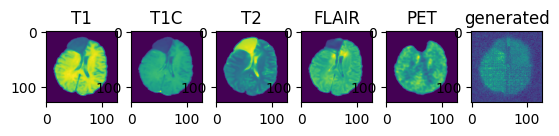

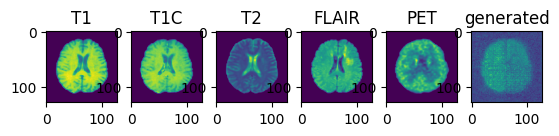

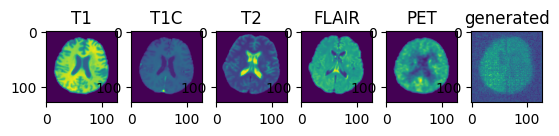

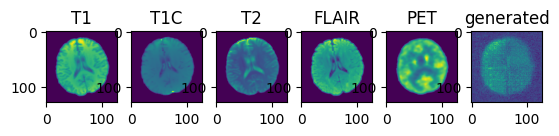

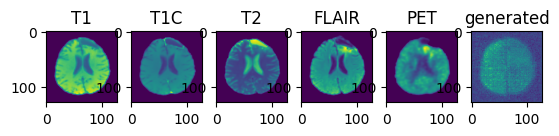

validation avg MS-SSIM: 0.3505 , train avg MS-SSIM: 0.3598
----------
epoch 49/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:34<07:52, 94.53s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:44, 41.05s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.98s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:31, 15.97s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.48s/it]

----------
epoch 50/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.11s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.75s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.43s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.92s/it]

----------
epoch 51/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.10s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.78s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.50s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:34, 17.04s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.43s/it]

----------
epoch 52/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:03, 96.80s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.01s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.66s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.35s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.79s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.91s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.72s/it]

----------
epoch 53/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:03, 96.74s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.02s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:14, 24.68s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.34s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.74s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.92s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.71s/it]

----------
epoch 54/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:56, 95.21s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:46, 41.60s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.26s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.13s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.61s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.81s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.47s/it]

----------
epoch 55/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:34<07:53, 94.69s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:44, 41.19s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.02s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:32, 16.02s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:49<00:11, 11.57s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.78s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.37s/it]

----------
epoch 56/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.58s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.15s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.15s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.67s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.21s/it]

----------
epoch 57/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.09s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.26s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.07s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:31, 15.98s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:49<00:11, 11.66s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.84s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.40s/it]

----------
epoch 58/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:32<07:41, 92.25s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:35<02:40, 40.10s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:39<01:10, 23.47s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:43<00:31, 15.64s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:47<00:11, 11.45s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00,  8.70s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00, 18.94s/it]

----------
epoch 59/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:48, 93.75s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.75s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.80s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:32, 16.01s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.58s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.79s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.19s/it]

----------
epoch 60/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:34<07:50, 94.05s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.87s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:12, 24.03s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:31, 15.98s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.54s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.77s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.28s/it]

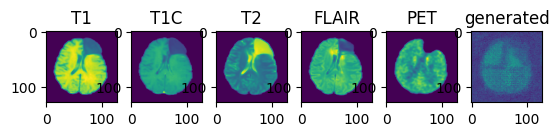

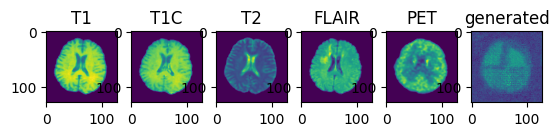

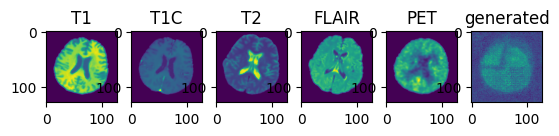

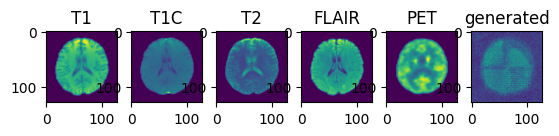

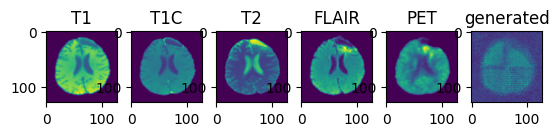

validation avg MS-SSIM: 0.3601 , train avg MS-SSIM: 0.3659
----------
epoch 61/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:49, 93.84s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:43, 40.78s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:41<01:11, 23.77s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:45<00:32, 16.00s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.57s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.78s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.26s/it]

----------
epoch 62/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:55, 95.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.27s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.05s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:33, 16.69s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  9.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.59s/it]

----------
epoch 63/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:20, 100.10s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.38s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.39s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.81s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.13s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.26s/it]

----------
epoch 64/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.87s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.69s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.57s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.92s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.34s/it]

----------
epoch 65/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.78s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.90s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.52s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.91s/it]

----------
epoch 66/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.55s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.73s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.43s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.28s/it]

----------
epoch 67/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.76s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.60s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.36s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.77s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.23s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.42s/it]

----------
epoch 68/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.31s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.43s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.33s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.77s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.32s/it]

----------
epoch 69/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.70s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.77s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.91s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.50s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.01s/it]

----------
epoch 70/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.82s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.24s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.16s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.19s/it]

----------
epoch 71/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:30, 102.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.19s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.82s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.07s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.57s/it]

----------
epoch 72/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:12, 98.46s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.65s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.87s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.50s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.93s/it]

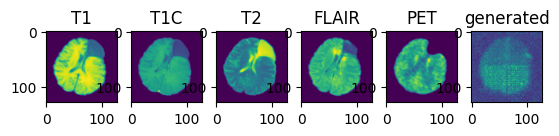

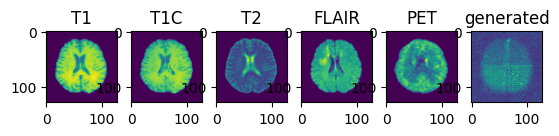

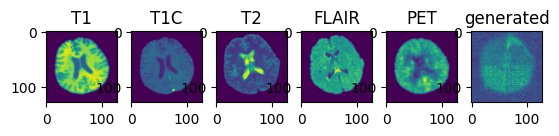

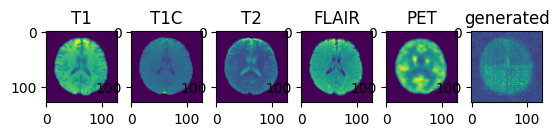

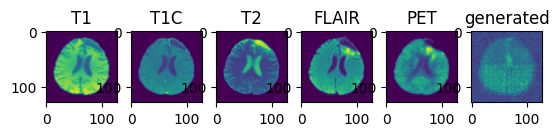

validation avg MS-SSIM: 0.3369 , train avg MS-SSIM: 0.3458
----------
epoch 73/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:30, 102.17s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.20s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.68s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.14s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.25s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.60s/it]

----------
epoch 74/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:43<08:35, 103.03s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:58, 44.52s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:18, 26.03s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:54<00:34, 17.21s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.31s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00,  9.25s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.68s/it]

----------
epoch 75/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.97s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.78s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.45s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.28s/it]

----------
epoch 76/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.94s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.71s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.79s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.26s/it]

----------
epoch 77/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.69s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.61s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.75s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.13s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.30s/it]

----------
epoch 78/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.75s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.76s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.92s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.52s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.97s/it]

----------
epoch 79/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:15, 99.16s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.98s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.01s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.57s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.04s/it]

----------
epoch 80/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.56s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.11s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.09s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.78s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.22s/it]

----------
epoch 81/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.47s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.06s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.25s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.72s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.11s/it]

----------
epoch 82/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:15, 99.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.90s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.16s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.66s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.09s/it]

----------
epoch 83/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:27, 101.40s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.21s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.68s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.96s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.46s/it]

----------
epoch 84/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:28, 101.64s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:55, 43.96s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.54s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.88s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.10s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.45s/it]

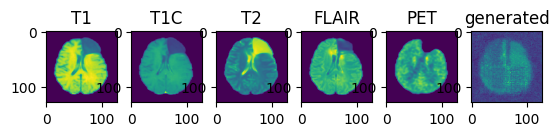

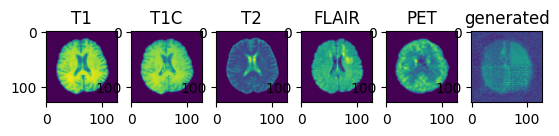

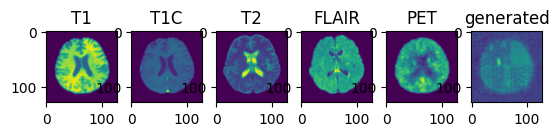

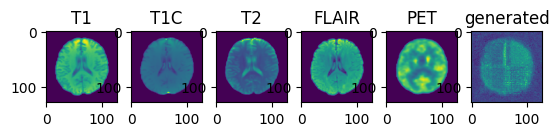

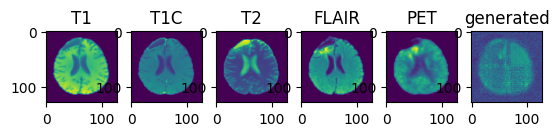

validation avg MS-SSIM: 0.3633 , train avg MS-SSIM: 0.3670
----------
epoch 85/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:30, 102.01s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.12s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:16, 25.62s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.90s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.46s/it]

----------
epoch 86/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:58, 95.66s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:46, 41.56s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:12, 24.30s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.18s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.66s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.56s/it]

----------
epoch 87/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:32<07:44, 92.81s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:41, 40.32s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:10, 23.59s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:43<00:31, 15.71s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:47<00:11, 11.46s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00,  8.70s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.02s/it]

----------
epoch 88/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:45, 93.20s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:42, 40.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:11, 23.69s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.79s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.54s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.74s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.10s/it]

----------
epoch 89/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:56, 95.24s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:38<02:45, 41.39s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:42<01:12, 24.12s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.17s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.63s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.82s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00, 19.40s/it]

----------
epoch 90/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:35<07:58, 95.62s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:46, 41.52s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:13, 24.43s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.23s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.67s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00,  8.84s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.52s/it]

----------
epoch 91/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:04, 96.96s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.05s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.50s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.29s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.73s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.87s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.66s/it]

----------
epoch 92/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.61s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.95s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.97s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.55s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.97s/it]

----------
epoch 93/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:27, 101.40s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:55, 43.91s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.56s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.91s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.16s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.44s/it]

----------
epoch 94/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:26, 101.27s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.87s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.49s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.84s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.39s/it]

----------
epoch 95/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.23s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.43s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.24s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.71s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.24s/it]

----------
epoch 96/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.77s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.63s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.19s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.36s/it]

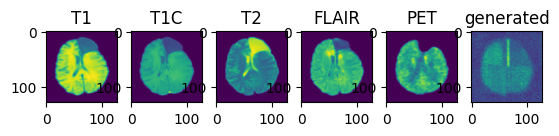

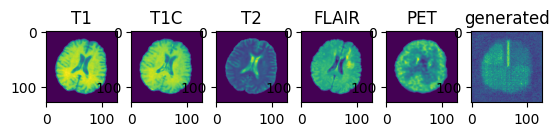

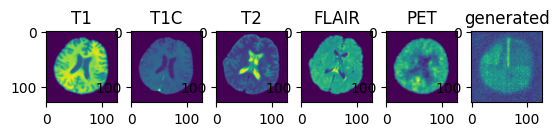

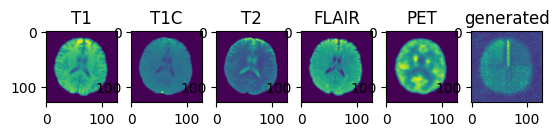

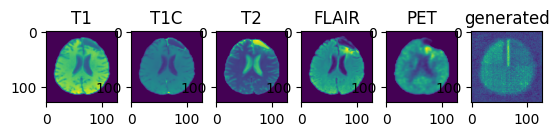

validation avg MS-SSIM: 0.3660 , train avg MS-SSIM: 0.3712
----------
epoch 97/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:32, 102.47s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.36s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.73s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.05s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.54s/it]

----------
epoch 98/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:04, 96.90s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.08s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.53s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.30s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.74s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  9.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.73s/it]

----------
epoch 99/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.72s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.79s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.88s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.49s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.02s/it]

----------
epoch 100/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.38s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.45s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.29s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.74s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.16s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.27s/it]

----------
epoch 101/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.57s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.13s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.11s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.78s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.17s/it]

----------
epoch 102/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:31, 102.40s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:57, 44.28s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.75s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.01s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.16s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.58s/it]

----------
epoch 103/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.26s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.45s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.43s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.81s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.25s/it]

----------
epoch 104/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.73s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.87s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.48s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.85s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.39s/it]

----------
epoch 105/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.77s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.17s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.09s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.63s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.91s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.02s/it]

----------
epoch 106/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.93s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.29s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.18s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.67s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.14s/it]

----------
epoch 107/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:32, 102.47s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.35s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.74s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.00s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.32s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.63s/it]

----------
epoch 108/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.82s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.65s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.44s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.19s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.38s/it]

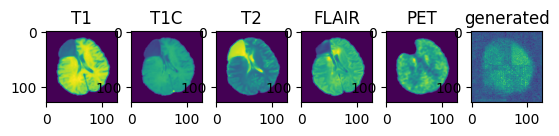

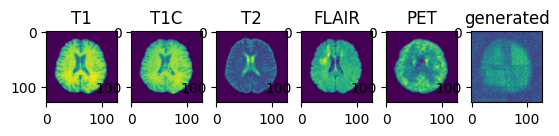

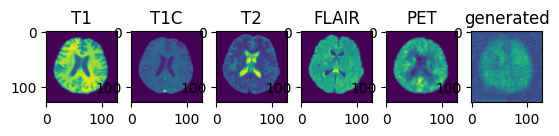

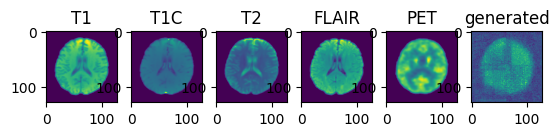

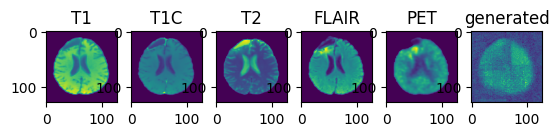

validation avg MS-SSIM: 0.3594 , train avg MS-SSIM: 0.3685
----------
epoch 109/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:20, 100.14s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.37s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.22s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.70s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.20s/it]

----------
epoch 110/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.05s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.49s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.79s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.43s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.83s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.97s/it]

----------
epoch 111/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:12, 98.40s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.66s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.82s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.48s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.87s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.90s/it]

----------
epoch 112/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:00, 96.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:46, 41.72s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:12, 24.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:46<00:32, 16.13s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.74s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.57s/it]

----------
epoch 113/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.82s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.23s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.18s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.14s/it]

----------
epoch 114/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.72s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.22s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.31s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.79s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.17s/it]

----------
epoch 115/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.63s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.22s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.77s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.12s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.20s/it]

----------
epoch 116/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.78s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.44s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.24s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.73s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.18s/it]

----------
epoch 117/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.41s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:56, 44.14s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.67s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.97s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.19s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.40s/it]

----------
epoch 118/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:48, 93.65s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:37<02:42, 40.68s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:11, 23.80s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.84s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.47s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:52<00:00,  8.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00, 19.26s/it]

----------
epoch 119/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:15, 99.11s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.96s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.01s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.59s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.93s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.08s/it]

----------
epoch 120/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.44s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.29s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.73s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.13s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.30s/it]

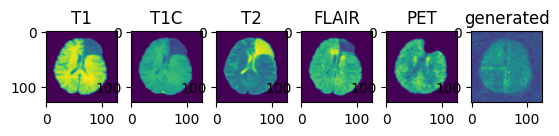

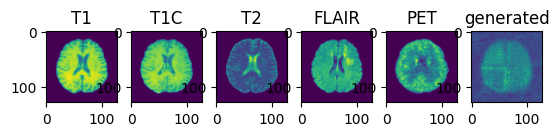

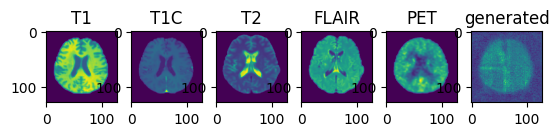

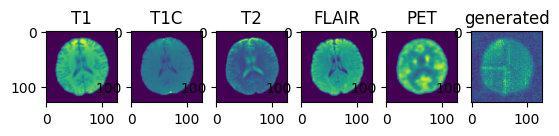

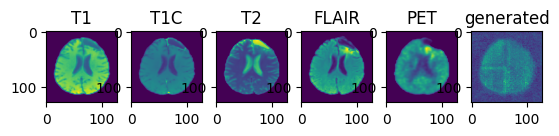

validation avg MS-SSIM: 0.3848 , train avg MS-SSIM: 0.3881
----------
epoch 121/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:33, 102.74s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:58, 44.66s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:17, 25.94s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:54<00:34, 17.13s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.28s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00,  9.23s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.75s/it]

----------
epoch 122/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.62s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.75s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.85s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.47s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.84s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  8.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.92s/it]

----------
epoch 123/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:33, 102.78s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.46s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:17, 25.83s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.07s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.26s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00,  9.35s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.77s/it]

----------
epoch 124/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.60s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.71s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.87s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.51s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:12, 12.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.97s/it]

----------
epoch 125/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:11, 98.36s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.61s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.79s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.41s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.98s/it]

----------
epoch 126/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.45s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.08s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.06s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.77s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.14s/it]

----------
epoch 127/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:08, 97.62s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.37s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:14, 24.67s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.61s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.92s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.85s/it]

----------
epoch 128/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.38s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.31s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.40s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.20s/it]

----------
epoch 129/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.38s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.76s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.23s/it]

----------
epoch 130/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.36s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.72s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.42s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.85s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.33s/it]

----------
epoch 131/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:33, 102.61s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.35s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.74s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:33, 17.00s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.19s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.62s/it]

----------
epoch 132/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 101.00s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.70s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.40s/it]

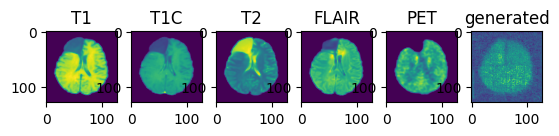

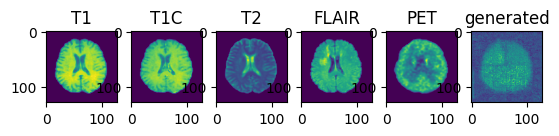

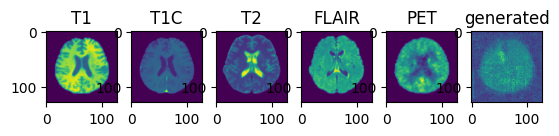

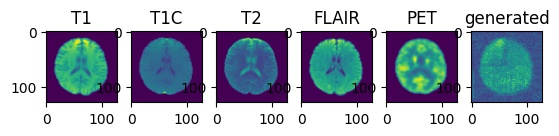

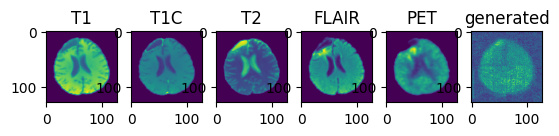

validation avg MS-SSIM: 0.3734 , train avg MS-SSIM: 0.3782
----------
epoch 133/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:12, 98.58s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:52, 43.04s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.03s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.58s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.98s/it]

----------
epoch 134/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:05, 97.10s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.32s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.66s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.36s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.75s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.94s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.76s/it]

----------
epoch 135/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:06, 97.23s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.16s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.56s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.34s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.75s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.69s/it]

----------
epoch 136/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:13, 98.62s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.74s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.88s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.50s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.03s/it]

----------
epoch 137/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:11, 98.35s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.63s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.82s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.48s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.05s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.94s/it]

----------
epoch 138/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:11, 98.33s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.63s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.81s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.46s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.96s/it]

----------
epoch 139/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:08, 97.66s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.37s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.66s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.56s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.88s/it]

----------
epoch 140/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:08, 97.78s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.42s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.73s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.55s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.89s/it]

----------
epoch 141/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.87s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.30s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.38s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.32s/it]

----------
epoch 142/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.76s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.89s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.52s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.95s/it]

----------
epoch 143/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.65s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.43s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.25s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.70s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.19s/it]

----------
epoch 144/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:32, 102.55s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.35s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.77s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.02s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.19s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.57s/it]

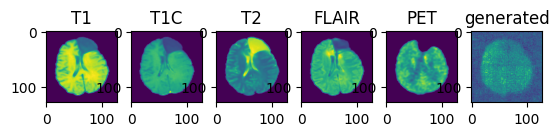

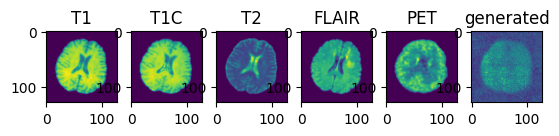

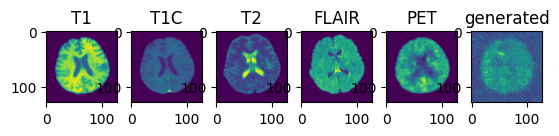

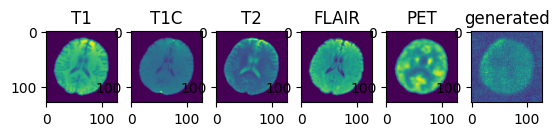

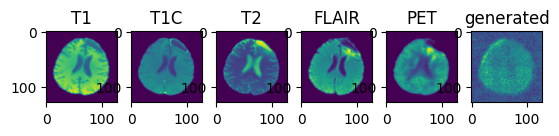

validation avg MS-SSIM: 0.3767 , train avg MS-SSIM: 0.3820
----------
epoch 145/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.96s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.90s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.24s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.71s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.11s/it]

----------
epoch 146/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.42s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.71s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.80s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.25s/it]

----------
epoch 147/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.43s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.32s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.19s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.66s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.94s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.11s/it]

----------
epoch 148/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:33, 102.78s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.47s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:17, 25.80s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.07s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.23s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.66s/it]

----------
epoch 149/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:42<08:33, 102.61s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:57, 44.41s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:17, 25.80s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.06s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.21s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.27s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.64s/it]

----------
epoch 150/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.98s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.32s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.16s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.65s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.96s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.19s/it]

----------
epoch 151/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.11s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:50, 42.54s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.78s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:32, 16.43s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.91s/it]

----------
epoch 152/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.11s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.74s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.93s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.12s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.33s/it]

----------
epoch 153/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.76s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.58s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.30s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.90s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.10s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.29s/it]

----------
epoch 154/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:28, 101.76s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:56, 44.06s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:49<01:16, 25.59s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.08s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00,  9.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.52s/it]

----------
epoch 155/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:49<09:06, 109.20s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:54<03:11, 47.95s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:58<01:24, 28.01s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [02:02<00:37, 18.62s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [02:06<00:13, 13.28s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:10<00:00, 10.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:13<00:00, 22.32s/it]

----------
epoch 156/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.07s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:49, 42.48s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.74s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.42s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.80s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.92s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.85s/it]

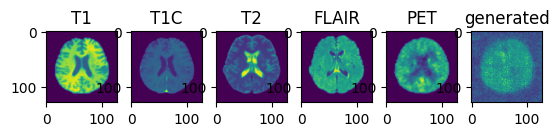

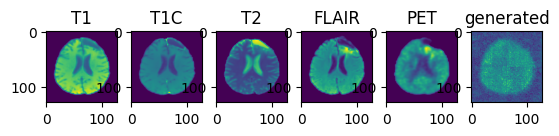

validation avg MS-SSIM: 0.3813 , train avg MS-SSIM: 0.3875
----------
epoch 157/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.37s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.09s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.04s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.58s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.91s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.02s/it]

----------
epoch 158/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.78s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.65s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.39s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.38s/it]

----------
epoch 159/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.82s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.63s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.33s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.92s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.34s/it]

----------
epoch 160/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.05s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.77s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.58s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.91s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.14s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.37s/it]

----------
epoch 161/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:17, 99.48s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.12s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.26s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.72s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.20s/it]

----------
epoch 162/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.13s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:46<02:59, 44.90s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:50<01:18, 26.08s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:53<00:34, 17.21s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:57<00:12, 12.33s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00,  9.29s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.72s/it]

----------
epoch 163/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.04s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:55, 43.96s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.54s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.88s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.40s/it]

----------
epoch 164/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:10, 98.09s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.73s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:45<01:14, 24.93s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.54s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:56<00:00,  9.00s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.94s/it]

----------
epoch 165/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:26, 101.23s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.83s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.48s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.86s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.10s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.12s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.38s/it]

----------
epoch 166/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:26, 101.37s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:45<02:55, 43.88s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.49s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.84s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.20s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.41s/it]

----------
epoch 167/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.45s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.51s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.34s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.77s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.32s/it]

----------
epoch 168/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:03, 96.62s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:47, 41.95s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:13, 24.46s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.22s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.66s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.97s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.70s/it]

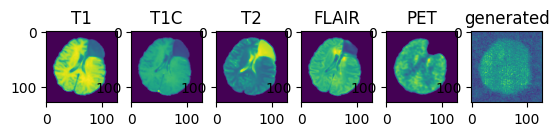

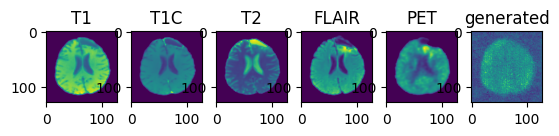

validation avg MS-SSIM: 0.3872 , train avg MS-SSIM: 0.3934
----------
epoch 169/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.54s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.56s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.75s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.01s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.23s/it]

----------
epoch 170/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.88s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.65s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.41s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.32s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.40s/it]

----------
epoch 171/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.97s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.92s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.99s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.57s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.90s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.07s/it]

----------
epoch 172/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.91s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.89s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.97s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.54s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.10s/it]

----------
epoch 173/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.17s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.80s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.46s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.83s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.22s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.23s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.43s/it]

----------
epoch 174/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.97s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.35s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.31s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.91s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.15s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.24s/it]

----------
epoch 175/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:00, 96.13s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:46, 41.71s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:12, 24.32s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.34s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.77s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  8.92s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.64s/it]

----------
epoch 176/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:33<07:46, 93.32s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:36<02:42, 40.54s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:40<01:11, 23.67s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:44<00:31, 15.93s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:48<00:11, 11.50s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:51<00:00,  8.76s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00, 19.16s/it]

----------
epoch 177/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:12, 98.51s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:50, 42.67s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.02s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.63s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.03s/it]

----------
epoch 178/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.28s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.23s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.17s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.66s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.95s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.13s/it]

----------
epoch 179/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:22, 100.43s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.73s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.42s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.30s/it]

----------
epoch 180/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.72s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.60s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.38s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.79s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.32s/it]

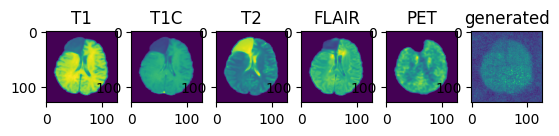

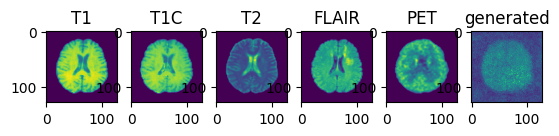

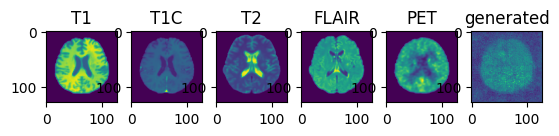

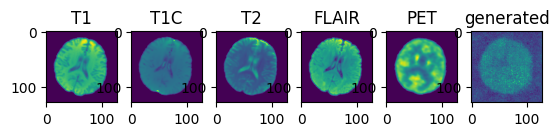

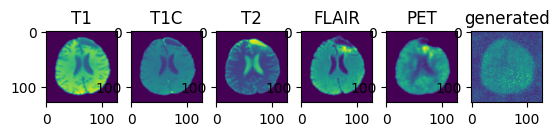

validation avg MS-SSIM: 0.3724 , train avg MS-SSIM: 0.3754
----------
epoch 181/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:16, 99.27s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.99s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.99s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.55s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.02s/it]

----------
epoch 182/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:20, 100.16s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.35s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.19s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.86s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.25s/it]

----------
epoch 183/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.39s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.43s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.46s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.85s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.13s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.27s/it]

----------
epoch 184/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:24, 100.88s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.68s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.38s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.82s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.07s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.10s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.29s/it]

----------
epoch 185/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.85s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:52, 43.05s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.06s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.61s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.02s/it]

----------
epoch 186/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:25, 101.01s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.71s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.38s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.79s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.04s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.35s/it]

----------
epoch 187/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:38<08:14, 98.98s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:51, 42.92s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:14, 24.96s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:49<00:33, 16.56s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:53<00:11, 11.88s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.10s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.07s/it]

----------
epoch 188/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:19, 99.94s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.29s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.16s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.73s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.25s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.25s/it]

----------
epoch 189/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:06, 97.27s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:40<02:48, 42.20s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.58s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.32s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:52<00:11, 11.89s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  8.98s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.78s/it]

----------
epoch 190/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:41<08:26, 101.35s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:55, 43.85s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:48<01:16, 25.49s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.87s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:56<00:12, 12.23s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.24s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.46s/it]

----------
epoch 191/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:18, 99.77s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:52, 43.18s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.14s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.70s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:11, 11.99s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.20s/it]

----------
epoch 192/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:23, 100.69s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:44<02:54, 43.60s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:16, 25.36s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:52<00:33, 16.95s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:55<00:12, 12.18s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:59<00:00,  9.17s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.39s/it]

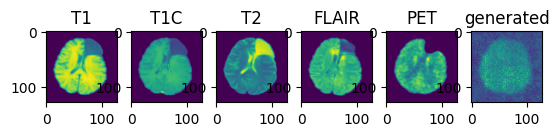

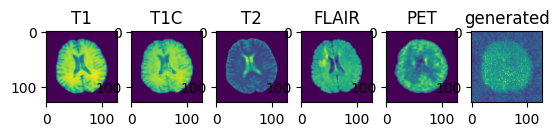

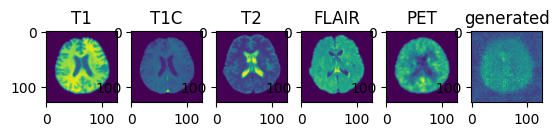

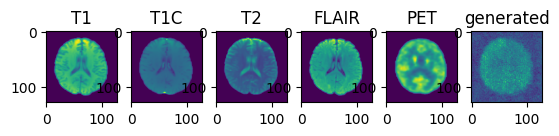

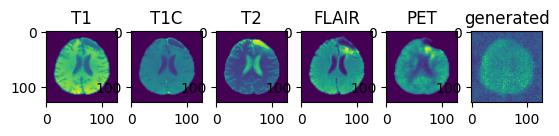

validation avg MS-SSIM: 0.3749 , train avg MS-SSIM: 0.3786
----------
epoch 193/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████                                                                                                              | 1/6 [01:40<08:21, 100.27s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:43<02:53, 43.46s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:47<01:15, 25.28s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:51<00:33, 16.73s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.02s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00,  9.09s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.24s/it]

----------
epoch 194/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:36<08:01, 96.27s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:39<02:47, 41.77s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:43<01:13, 24.34s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:47<00:32, 16.17s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:50<00:11, 11.64s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:54<00:00,  9.06s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.67s/it]

----------
epoch 195/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:37<08:06, 97.38s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:41<02:48, 42.25s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:44<01:13, 24.64s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:48<00:32, 16.32s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:51<00:11, 11.73s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:55<00:00,  9.03s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:58<00:00, 19.79s/it]

----------
epoch 196/196


Epoch :   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]

Epoch :  17%|██████████████████████▏                                                                                                              | 1/6 [01:39<08:15, 99.06s/it]

Epoch :  33%|████████████████████████████████████████████▎                                                                                        | 2/6 [01:42<02:52, 43.08s/it]

Epoch :  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 3/6 [01:46<01:15, 25.04s/it]

Epoch :  67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4/6 [01:50<00:33, 16.60s/it]

Epoch :  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5/6 [01:54<00:12, 12.08s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00,  9.11s/it]

Epoch : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:00<00:00, 20.13s/it]

In [12]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0
max_epochs = 196
disc_train_interval = 1
disc_train_steps = 1
validation_interval = 12
best_ssim = 0
torch.cuda.empty_cache()

for epoch in range(max_epochs):
    
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    for batch_data in tqdm(train_loader, desc=("Epoch ")):
        input_images = torch.cat((batch_data["t1"].to(device, dtype=torch.float), 
                                 batch_data["t1c"].to(device, dtype=torch.float), 
                                 batch_data["t2"].to(device, dtype=torch.float), 
                                 batch_data["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        real_pet = batch_data["pet"].to(device, dtype=torch.float)
        
        gen_images = gen_net(input_images)
        gen_opt.zero_grad()
        loss = generator_loss(gen_images, real_pet)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        real_pet = real_pet[:,0,:,:,:]
        gen_images = gen_images[:,0,:,:,:]

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_pet)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))
        step += 1
    
    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

    if (epoch+1) % validation_interval == 0:
        gen_net.eval()
        slice_index = 32
        ms_ssim = []
        ms_ssim_train = []
        ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)
        
        with torch.no_grad():

            for item in train_metric_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)
                
                generated = gen_net(input_images)
                ms_ssim_train.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))

            curr_ssim_train = torch.mean(torch.FloatTensor(ms_ssim_train))
            
            for item in valid_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

                generated = gen_net(input_images)
        
                image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
                f, axarr = plt.subplots(1, 6)

                ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
                axarr[0].imshow(image_datas[0])
                axarr[0].set_title("T1")
                axarr[1].imshow(image_datas[1])
                axarr[1].set_title("T1C")
                axarr[2].imshow(image_datas[2])
                axarr[2].set_title("T2")
                axarr[3].imshow(image_datas[3])
                axarr[3].set_title("FLAIR")
                axarr[4].imshow(image_datas[4])
                axarr[4].set_title("PET")
                axarr[5].imshow(image_datas[5].cpu())
                axarr[5].set_title("generated")
                plt.show()
                
            curr_ssim = torch.mean(torch.FloatTensor(ms_ssim))

            if curr_ssim > best_ssim:
                best_ssim = curr_ssim
                torch.save({
                        'epoch': epoch,
                        'model_state_dict': gen_net.state_dict(),
                        'optimizer_state_dict': gen_opt.state_dict(),
                        }, "best_metric_glagan.pth")
                
        print("validation avg MS-SSIM: {:.4f} , train avg MS-SSIM: {:.4f}".format(curr_ssim, curr_ssim_train))
            

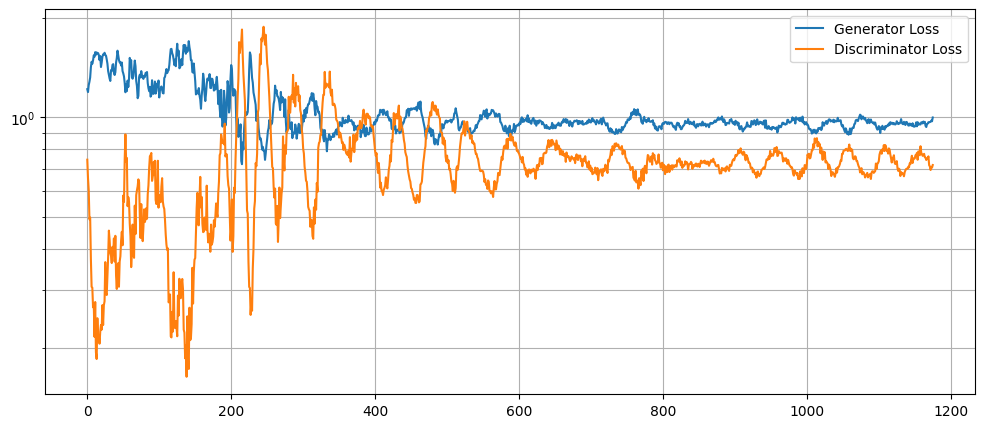

In [13]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

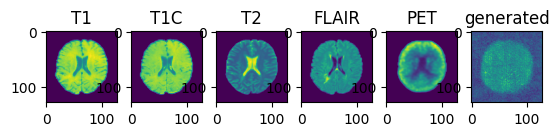

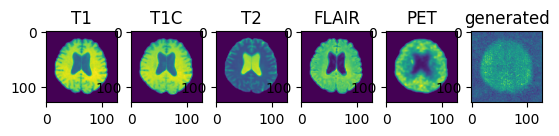

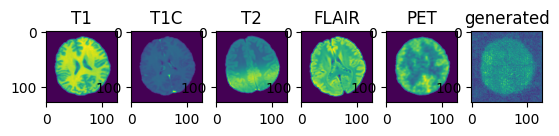

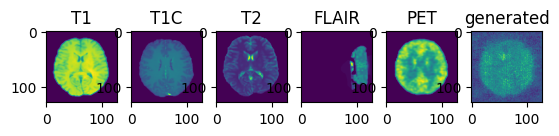

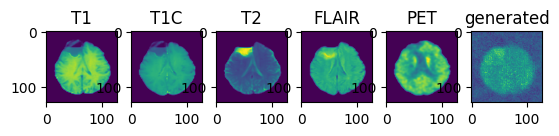

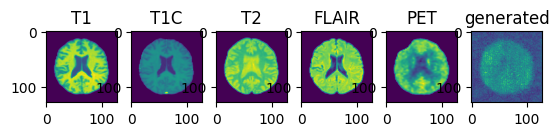

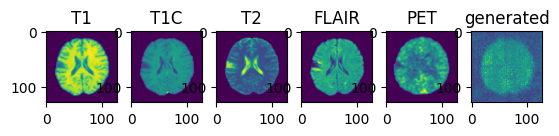

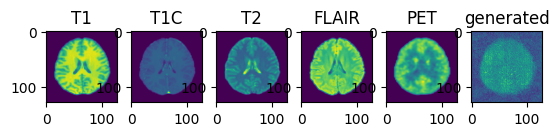

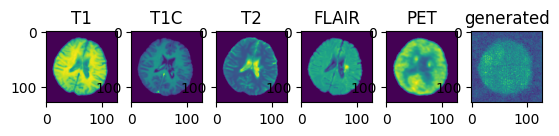

It has been 27280.498849868774 seconds since the loop started
validation avg MS-SSIM: 0.3874 validation avg MSE 0.0000


In [14]:

slice_index = 32

torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_glagan.pth")
gen_net.load_state_dict(saved_dict['model_state_dict'])
gen_net.eval()

ms_ssim = []
ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)

for item in check_DataLoader:

    with torch.no_grad():
        
        input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        generated = gen_net(input_images)
        
        image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
        f, axarr = plt.subplots(1, 6)

        ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
        axarr[0].imshow(image_datas[0])
        axarr[0].set_title("T1")
        axarr[1].imshow(image_datas[1])
        axarr[1].set_title("T1C")
        axarr[2].imshow(image_datas[2])
        axarr[2].set_title("T2")
        axarr[3].imshow(image_datas[3])
        axarr[3].set_title("FLAIR")
        axarr[4].imshow(image_datas[4])
        axarr[4].set_title("PET")
        axarr[5].imshow(image_datas[5].cpu())
        axarr[5].set_title("generated")
        plt.show()


now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

print("validation avg MS-SSIM: {:.4f} validation avg MSE {:.4f}".format(torch.mean(torch.FloatTensor(ms_ssim)), 0))